In [1]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Modify sys path to import top-level modules
import sys
import itertools
sys.path.append("..")
from utils.utils import(
    delete_data_folder_structure,
    show_image,
    parse_class_report,
    split_folder_of_images,
)
#from models.mobilenetv2_model import MobileNetV2Model
#from models.mobilenetv2_antialias_model import MobileNetV2ModelAntiAlias
#from models.resnet_antialias_model import ResNetModelAntiAlias
from models.resnet_model import ResNetModel

# Fix random seed for reproducibility
seed = 9102
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Global device config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using GPU for acceleration") if torch.cuda.is_available() else print(
    "Using CPU for computation"
)

# Image folder path (zoom level 18)
base_path = Path("datasets")
shuffle_all_images = False
pretrain_model = ["resnet18", "resnet18_aa", "mobilenetv2", "mobilenetv2_aa"][0]

# Output files
saved_model_filename = f"cell_classifier_model_{pretrain_model}.pt"
labels_mapping_filename = f"cell_classifier_labels_{pretrain_model}.pkl"

# Data split
train_prop = 0.8  # (taken from ALL the data)
valid_prop = 0.2  # (taken only from TRAIN)

# Hyperparameters
batch_size = 16
lr = 0.0001
epochs = 25

# Tensorboard: writer will output to ./runs/ directory by default
comment = f"_T{round(train_prop*100)}_V{round(valid_prop*100)}_BS{batch_size}_LR{round(lr*10000)}_{pretrain_model}"
writer = SummaryWriter(comment=comment)

Using GPU for acceleration


2022-08-14 02:55:37.090665: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-08-14 02:55:37.090707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Split files in folders
if shuffle_all_images:
    delete_data_folder_structure(base_path=base_path)
    split_folder_of_images(base_path=base_path, train_prop=train_prop, valid_prop=valid_prop, seed=seed)

In [3]:
image_size = (224, 224)

# Using the mean and std of Imagenet for transformations
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(1, 179)),
        transforms.RandomAffine(degrees=0, scale=(1.01, 1.20)),
        transforms.ColorJitter(brightness=(0.8, 1.2)),        
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ]
)

In [4]:
train = ImageFolder(root=Path(base_path / "train"), transform=train_transform)
validation = ImageFolder(root=Path(base_path / "validation"), transform=test_transform)
test = ImageFolder(root=Path(base_path / "test"), transform=test_transform)

print(f"Dataset classes: {train.classes}")
print(
    f"Training images: {len(train)} | Validation images: {len(validation)} | Testing images: {len(test)}"
)

Dataset classes: ['not_school', 'school']
Training images: 10849 | Validation images: 2711 | Testing images: 3391


In [6]:
def images_to_probs(model, images):
    """
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    """
    images = images.to(device)
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output.detach().cpu(), 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(model, images, labels, classes, rows=12):
    """
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    """
    preds, probs = images_to_probs(model, images)
    nimg = len(preds)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 40))
    for idx in np.arange(nimg):
        image = images[idx].detach().cpu()
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array(means)
        std = np.array(stds)
        image = ((std * image + mean) * 255).astype('uint8')
        ax = fig.add_subplot(rows, nimg / rows, idx + 1)
        plt.axis('off')
        plt.imshow(image)
        pred = classes[preds[idx]].upper().replace("_", "-")
        obs = classes[labels[idx]].upper().replace("_", "-")
        ax.set_title(
            f"PRED: {pred} ({round(probs[idx] * 100.0, 2)}%)\nOBS: {obs}",
            color=("green" if preds[idx] == labels[idx] else "red"),
        )
    fig.tight_layout()
    return fig


def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0

    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad()

        predictions = training_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        labels = labels.long()

        loss = criterion(predictions, labels.to(device))
        # loss = criterion(torch.max(F.softmax(predictions, dim=1), dim=1)[0], labels.to(device))        

        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    val_loss = 0

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            predictions = val_model(images.to(device))
            labels = labels.long()
            loss = criterion(predictions, labels.to(device))
            val_loss += loss.item()
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.topk(1, dim=1)[1].cpu().numpy().tolist())

    accuracy = accuracy_score(all_targets, all_predictions)

    return val_loss / len(loader), accuracy * 100


def train_model(
    target_model, number_epochs, criterion, optim, train_iterator, valid_iterator
):
    # Stats trackers
    train_history = []
    valid_history = []
    accuracy_history = []

    begin_time = time.time()
    best_val_acc = 0.0

    for epoch in range(number_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(
            target_model, train_iterator, criterion, optim
        )
        train_history.append(train_loss)
        print(
            "Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, train_loss, train_acc, time.time() - start_time
            )
        )

        start_time = time.time()
        val_loss, acc = validation_epoch(target_model, valid_iterator, criterion)
        valid_history.append(val_loss)
        accuracy_history.append(acc)
        print(
            "Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, val_loss, acc, time.time() - start_time
            )
        )

        # Tensorboard
        writer.add_scalars(
            "Learning curves/Loss",
            {"train": train_loss, "validation": val_loss},
            epoch + 1,
        )
        writer.add_scalars(
            "Learning curves/Accuracy",
            {"train": train_acc, "validation": acc},
            epoch + 1,
        )

        # Checkpoint model
        if acc > best_val_acc:
            torch.save(model.state_dict(), saved_model_filename)
            best_val_acc = acc
            print("* Found new best accuracy")

    print(
        "Total time for {} epochs: {:.2f} minutes".format(
            number_epochs, (time.time() - begin_time) / 60
        )
    )

    return train_history, valid_history, accuracy_history


def test_model(trained_model, test_iterator):
    test_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_iterator:
            predictions = trained_model(images.to(device))
            test_labels.extend(labels.cpu().numpy())
            all_predictions.extend(
                predictions.topk(1, dim=1)[1].squeeze().cpu().numpy()
            )

    return test_labels, all_predictions


def plot_stats(x_axis, train_loss, valid_loss, valid_acc):
    # Set matplotlib default plot size
    plt.rcParams["figure.figsize"] = [7, 5]

    # Loss
    plt.title("Train and Validation Loss")
    plt.plot(x_axis, train_loss, label="Train Loss")
    plt.plot(x_axis, valid_loss, label="Validation Loss")
    plt.legend()
    plt.show()

    # Accuracy
    plt.title("Validation Accuracy")
    plt.plot(x_axis, valid_acc)
    plt.show()


def plot_confusion_matrix(
    cm, used_labels, target_names, title="Confusion matrix", cmap="Blues"
):
    accuracy = np.trace(cm) / np.sum(cm).astype("float")
    misclass = 1 - accuracy
    cmap = plt.get_cmap(cmap)

    plt.figure(figsize=(15, 10))
    tick_marks = np.arange(len(used_labels))
    names = [target_names[idx] for idx in used_labels]
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            "{:,}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel(
        "Predicted label\n\nAccuracy: {:0.2f}%; Misclass: {:0.2f}%".format(
            accuracy * 100, misclass * 100
        )
    )
    plt.show()

In [7]:
# Define model hyperparameters
number_classes = len(train.classes)
pretrained = True
fs = 4

if pretrain_model == "resnet18_aa":
    model = ResNetModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "mobilenetv2_aa":
    model = MobileNetV2ModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "resnet18":
    model = ResNetModel(n_classes=number_classes, pretrained=pretrained)
else:
    model = MobileNetV2Model(n_classes=number_classes, pretrained=pretrained)
    
model.to(device)
print(model)
print(f"Number of trainable parameters {model.summary()}")

# Use BinaryCrossEntropy 
# loss_function = nn.BCEWithLogitsLoss().to(device)
# loss_function = nn.BCELoss().to(device)
loss_function = nn.CrossEntropyLoss().to(device)

ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [13]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
# Training
train_loss_history = []
valid_loss_history = []
accuracy_history = []
all_epochs = 0

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the model and update stats
print(f"Start training pretrained model {pretrain_model} with {lr} learning rate, batch size of {batch_size} and {epochs} epochs")
train_losses, valid_losses, accuracies = train_model(
    model, epochs, loss_function, optimizer, train_loader, val_loader
)
train_loss_history.extend(train_losses)
valid_loss_history.extend(valid_losses)
accuracy_history.extend(accuracies)
all_epochs += epochs

# Tensorboard
writer.flush()

Start training pretrained model resnet18 with 0.0001 learning rate, batch size of 16 and 25 epochs
Training epoch 1 | Loss 0.319449 | Accuracy 87.44% | Time 890.77 seconds
Validation epoch 1 | Loss 0.267505 | Accuracy 90.23% | Time 222.75 seconds
* Found new best accuracy
Training epoch 2 | Loss 0.251005 | Accuracy 90.96% | Time 935.32 seconds
Validation epoch 2 | Loss 0.224172 | Accuracy 91.11% | Time 229.82 seconds
* Found new best accuracy
Training epoch 3 | Loss 0.223025 | Accuracy 91.84% | Time 724.41 seconds
Validation epoch 3 | Loss 0.253660 | Accuracy 89.75% | Time 168.23 seconds
Training epoch 4 | Loss 0.219259 | Accuracy 92.06% | Time 703.69 seconds
Validation epoch 4 | Loss 0.195602 | Accuracy 92.92% | Time 148.29 seconds
* Found new best accuracy
Training epoch 5 | Loss 0.202602 | Accuracy 92.78% | Time 716.38 seconds
Validation epoch 5 | Loss 0.191346 | Accuracy 92.99% | Time 209.43 seconds
* Found new best accuracy
Training epoch 6 | Loss 0.197966 | Accuracy 93.02% | Time

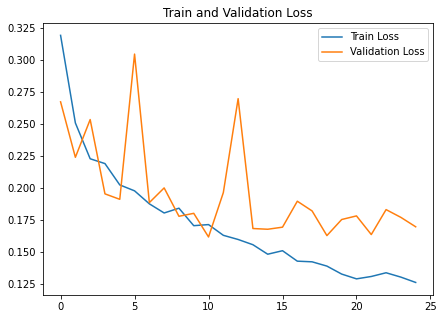

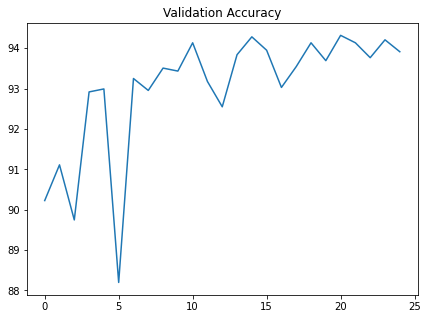

In [15]:
plot_stats(range(all_epochs), train_loss_history, valid_loss_history, accuracy_history)


In [9]:
if pretrain_model == "resnet18_aa":
    model = ResNetModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "mobilenetv2_aa":
    model = MobileNetV2ModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "resnet18":
    model = ResNetModel(n_classes=number_classes, pretrained=pretrained)
else:
    model = MobileNetV2Model(n_classes=number_classes, pretrained=pretrained)
    
model.load_state_dict(torch.load(saved_model_filename))
model.to(device)
model.eval()

ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

Couldn't add figures to Tensorboard from batch 212


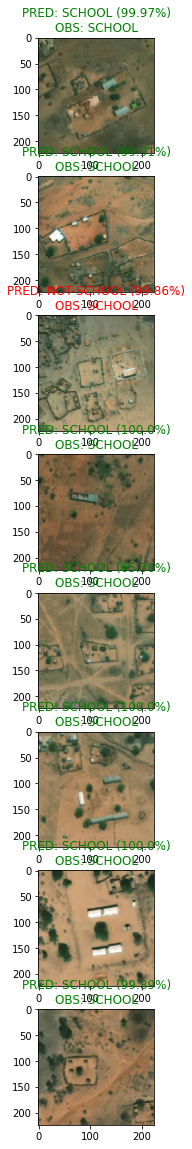

In [132]:
all_predictions = []
all_test_images = []
all_true_labels = []
all_used_labels = set()

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        labels = labels.numpy()
        all_true_labels.extend(labels)
        all_used_labels.update(labels)
        all_test_images.extend(images)
        images = images.to(device)
        current_preds = model(images)
        all_predictions.extend(F.softmax(current_preds.detach().cpu(), dim=1))
        
        # Tensorboard
        try:
            writer.add_figure(
               f"Test/Batch_prediction_{i+1}",
                plot_classes_preds(model, images, labels, test.classes),
            )
        except Exception:
            print(f"Couldn't add figures to Tensorboard from batch {i+1}")

# Tensorboard
writer.flush()

# Get all predictions and probabilities 
all_predictions = torch.stack(all_predictions)
probabilities = torch.max(all_predictions, dim=1)[0]
votes = torch.argmax(all_predictions, dim=1).numpy()
labels = np.array(train.classes)

In [114]:
print(all_predictions)

tensor([[9.5854e-01, 4.1459e-02],
        [9.7947e-01, 2.0533e-02],
        [8.8360e-01, 1.1640e-01],
        ...,
        [3.5387e-06, 1.0000e+00],
        [8.9017e-06, 9.9999e-01],
        [2.2995e-06, 1.0000e+00]])


In [126]:
smth = torch.max(all_predictions, dim=1)[1]

In [127]:
print(smth)

tensor([0, 0, 0,  ..., 1, 1, 1])


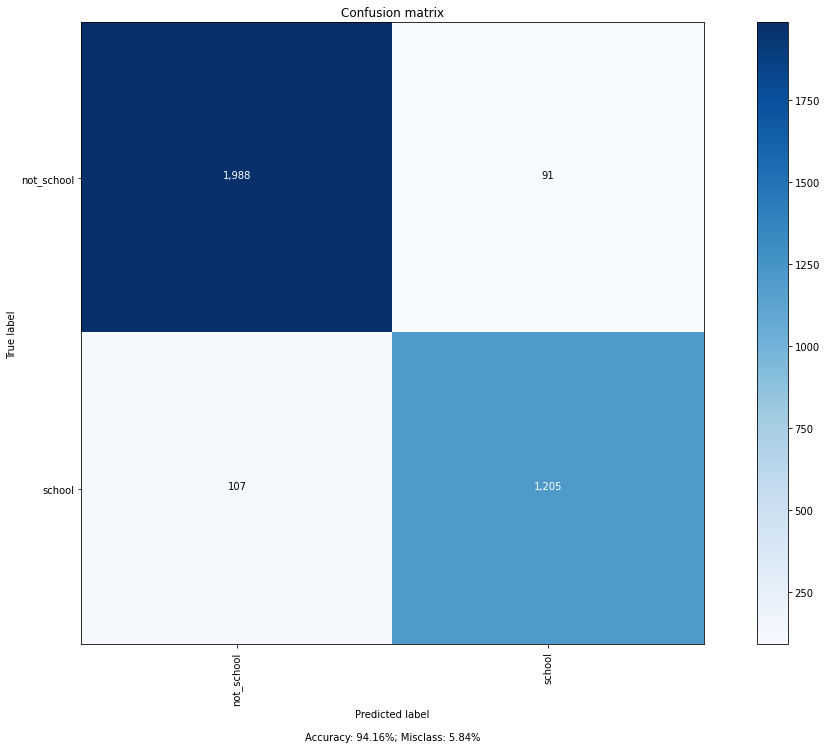

              precision    recall  f1-score   support

  not_school      0.949     0.956     0.953      2079
      school      0.930     0.918     0.924      1312

    accuracy                          0.942      3391
   macro avg      0.939     0.937     0.938      3391
weighted avg      0.942     0.942     0.942      3391



In [18]:
# Plot confusion matrix of results
conf_mat = confusion_matrix(all_true_labels, votes)
plot_confusion_matrix(cm=conf_mat, used_labels=all_used_labels, target_names=labels, title="Confusion matrix")
print(classification_report(all_true_labels, votes, target_names=labels, digits=3))

# Tensorboard
classif_report_dict = classification_report(all_true_labels, votes, target_names=labels, digits=3, output_dict=True)
writer.add_text(f"Test_classif_report/all", parse_class_report(classif_report_dict, "not_cell"))
writer.add_text(f"Test_classif_report/all", parse_class_report(classif_report_dict, "cell"))
writer.add_text(f"Test_classif_report/all", f"accuracy: {round(classif_report_dict.get('accuracy'), 3)}")

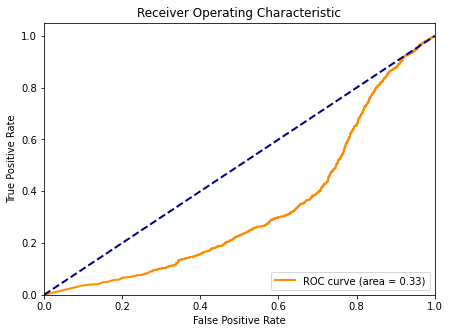

In [19]:
fpr, tpr, thresholds = roc_curve(np.array(all_true_labels), probabilities.numpy(), pos_label=0)
roc_auc = auc(x=fpr, y=tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [10]:
if pretrain_model == "resnet18_aa":
    model = ResNetModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "mobilenetv2_aa":
    model = MobileNetV2ModelAntiAlias(n_classes=number_classes, pretrained=pretrained, filter_size=fs)
elif pretrain_model == "resnet18":
    model = ResNetModel(n_classes=number_classes, pretrained=pretrained)
else:
    model = MobileNetV2Model(n_classes=number_classes, pretrained=pretrained)
    
model.load_state_dict(torch.load(saved_model_filename))
model.to(device)
model.eval()

ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
new_images = ImageFolder(root=Path(base_path / "new1"), transform=test_transform)
new_loader = DataLoader(new_images, batch_size=batch_size, shuffle=False, pin_memory=True)
#val_loader = DataLoader(validation, batch_size=batch_size, shuffle=False, pin_memory=True)
#test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
test_predictions = []
test_images = []
#all_true_labels = []
used_labels = set()

with torch.no_grad():
    for i, data in enumerate(new_loader, 0):
        images, labels = data
        labels = labels.numpy()
        #all_true_labels.extend(labels)
        used_labels.update(labels)
        test_images.extend(images)
        images = images.to(device)
        c_preds = model(images)
        test_predictions.extend(F.softmax(c_preds.detach().cpu(), dim=1))
        
        # Tensorboard
        #try:
            #writer.add_figure(
                 #f"Test/Batch_prediction_{i+1}",
                 #plot_classes_preds(model, images, labels, test.classes),
             #)
        #except Exception:
                #print(f"Couldn't add figures to Tensorboard from batch {i+1}")

# Tensorboard
#writer.flush()

# Get all predictions and probabilities 
test_predictions = torch.stack(test_predictions)
c_probabilities = torch.max(test_predictions, dim=1)[0]
c_votes = torch.argmax(test_predictions, dim=1).numpy()
labels = np.array(train.classes)

In [27]:
import pandas as pd
dff = pd.DataFrame(c_votes)

In [28]:
dff.head()

,0
0,1
1,0
2,0
3,0
4,0


In [120]:
dff[0].value_counts()

0    28
1    26
Name: 0, dtype: int64